<a href="https://colab.research.google.com/github/Daniel-Karlik/Parliament_Spotlight_NLP/blob/dev_model/Prototype_hierarchic_K_means%2C_TF_IDF_Parliament_Spotlight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import glob
import re
import string

In [2]:
#from google.colab import auth
from google.colab import drive
#auth.authenticate_user()

In [3]:
drive.mount('/content/drive/')
# Path to our data on google drive
DATA_PATH = "/content/drive/MyDrive/NLP/"

Mounted at /content/drive/


## Now we can use TF-IDF

In [4]:
psp_data = pickle.load(open('/content/drive/MyDrive/NLP/Changed/psp_data_300_no_stopwords.pickle', 'rb'))

In [5]:
test_data = psp_data.sample(frac=0.2)

In [6]:
test_data.head()

,Id,obdobi,datum,schuze,celeJmeno,OsobaId,funkce,tema,text,pocetSlov,politiciZminky
39709,2002_18_01587,2002,2003-07-03T00:00:00+02:00,18,Ivan Langer,ivan-langer,Místopředseda PSP,(,vážený pane předsedo kolegyně kolegové odpověď...,1225,"[jiri-bily, jiri-bily-1]"
43703,1998_36_01638,1998,2001-05-24T00:00:00+02:00,36,Karel Vymětal,karel-vymetal,Poslanec,bod 39,slovo pane předsedající dámy pánové přesvědčen...,615,[pavel-mertlik]
26003,2010_19_01439,2010,2011-06-16T00:00:00+02:00,19,ČR Josef Dobeš,josef-dobes,"Ministr školství, mládeže a tělovýchovy",113. Odpovědi členů vlády na písemné interpelace,vážená předsedající vážená poslankyně dámy pán...,465,[]
12398,2017_6_01322,2017,2018-01-25T00:00:00+01:00,6,ČR Tomáš Hüner,tomas-huner,Ministr průmyslu a obchodu,41. Ústní interpelace,slovo vážený pane předsedající vážené poslanky...,370,[]
48393,1998_9_00745,1998,1999-02-09T00:00:00+01:00,9,Ivan Pilip,ivan-pilip,Poslanec,,dámy pánové vážená vládo pane předsedající jed...,1765,[karel-kuhnl]


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9790 entries, 39709 to 48470
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              9790 non-null   object
 1   obdobi          9790 non-null   int64 
 2   datum           9790 non-null   object
 3   schuze          9790 non-null   int64 
 4   celeJmeno       9790 non-null   object
 5   OsobaId         9508 non-null   object
 6   funkce          9790 non-null   object
 7   tema            9790 non-null   object
 8   text            9790 non-null   object
 9   pocetSlov       9790 non-null   int64 
 10  politiciZminky  9477 non-null   object
dtypes: int64(3), object(8)
memory usage: 917.8+ KB


Test sample has 20% of our data, i.e. 9790.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
tfidf_vectorizer = TfidfVectorizer(input='content', max_features = 500, max_df = 0.7, ngram_range=(1, 2)) # Hopefully stop_words will be filtered by TD-IDF mechanism
# ngram_range=(1, 1) only unigram, ngram_range=(1, 2) uni and bigrams

In [10]:
tfidf_vector = tfidf_vectorizer.fit_transform(test_data['text']) # Run time 146s

In [11]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # HERE IT CRASHES with too high max_features 

In [12]:
#tfidf_df.loc['00_Document Frequency'] = (tfidf_df > 0).sum()

### First glance at our featured words

In [13]:
print(tfidf_df)

           bod      bodu  body    bychom  bychom měli       byť     celou  \
0     0.000000  0.000000   0.0  0.000000     0.000000  0.000000  0.000000   
1     0.000000  0.000000   0.0  0.000000     0.000000  0.000000  0.000000   
2     0.000000  0.000000   0.0  0.000000     0.000000  0.000000  0.098877   
3     0.000000  0.000000   0.0  0.000000     0.000000  0.000000  0.220577   
4     0.046917  0.024388   0.0  0.000000     0.000000  0.053765  0.000000   
...        ...       ...   ...       ...          ...       ...       ...   
9785  0.000000  0.000000   0.0  0.000000     0.000000  0.000000  0.000000   
9786  0.000000  0.000000   0.0  0.044022     0.000000  0.067567  0.000000   
9787  0.000000  0.000000   0.0  0.000000     0.000000  0.000000  0.133156   
9788  0.000000  0.000000   0.0  0.029176     0.000000  0.000000  0.000000   
9789  0.000000  0.000000   0.0  0.092357     0.046271  0.000000  0.000000   

      celá      celé      celý  ...      říct     říkal     říká     říkám 

### Now we remove this auxiliary row

In [14]:
#tfidf_df = tfidf_df.drop('00_Document Frequency', errors='ignore')

In [15]:
tfidf_df.stack().reset_index()

,level_0,level_1,0
0,0,bod,0.0
1,0,bodu,0.0
2,0,body,0.0
3,0,bychom,0.0
4,0,bychom měli,0.0
...,...,...,...
4894995,9789,škol,0.0
4894996,9789,školství,0.0
4894997,9789,školy,0.0
4894998,9789,životního,0.0


### We rename columns to be more understandables

In [16]:
tfidf_df = tfidf_df.stack().reset_index() # This is necessary for some reason

In [17]:
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document_id','level_1': 'term'})

In [18]:
tfidf_df.sort_values(by=['document_id','tfidf'], ascending=[True,False]).groupby(['document_id']).head(3)

,document_id,term,tfidf
107,0,ministr,0.330130
277,0,předpisů,0.232749
45,0,důvody,0.229235
887,1,veřejné,0.414420
851,1,státní,0.311667
...,...,...,...
4894016,9788,demokracie,0.362222
4894391,9788,vládní,0.319056
4894812,9789,samozřejmě,0.341391
4894768,9789,právo,0.297301


We can see above top 3 keywords for each document

## Results above seems promising

## Hierarchic k-means

In [19]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_vector)

clusters = km.labels_.tolist()

In [20]:
print(tfidf_vector)

  (0, 231)	0.04703527296805994
  (0, 205)	0.11414360449191228
  (0, 473)	0.08691135749326157
  (0, 83)	0.04433039213635484
  (0, 208)	0.05233062561246555
  (0, 407)	0.035076365698599975
  (0, 328)	0.03857333674453431
  (0, 229)	0.03539565293731092
  (0, 192)	0.05791667458418724
  (0, 224)	0.03771832408788122
  (0, 362)	0.04512972231206212
  (0, 488)	0.04754531850843273
  (0, 449)	0.03505564271173721
  (0, 180)	0.05359998316876447
  (0, 338)	0.05238961500816853
  (0, 17)	0.05355236404624273
  (0, 85)	0.15329124137363
  (0, 444)	0.05662680113131035
  (0, 238)	0.21276708323482985
  (0, 213)	0.04962109965145837
  (0, 346)	0.08687695216111428
  (0, 177)	0.05288448016571795
  (0, 344)	0.05282370156562254
  (0, 178)	0.04382113254711306
  (0, 293)	0.053904798646843034
  :	:
  (9789, 142)	0.04444296647451882
  (9789, 116)	0.03621089559041993
  (9789, 59)	0.1014636189329794
  (9789, 79)	0.04450349663544329
  (9789, 236)	0.19614610628675597
  (9789, 377)	0.028336829156985644
  (9789, 136)	0.04336

In [21]:
#print(tfidf_vector.shape[0])
#tfidf_vector[0,352]

Funkce selectujici dane clustery.

In [22]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # HERE IT CRASHES with too high max_features 

In [23]:
tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9790 entries, 0 to 9789
Columns: 500 entries, bod to životního prostředí
dtypes: float64(500)
memory usage: 37.3 MB


In [24]:
#tfidf_df.info() # 9790 x 500
tfidf_df['cluster'] = clusters

In [25]:
tfidf_df.head()

,bod,bodu,body,bychom,bychom měli,byť,celou,celá,celé,celý,...,říkal,říká,říkám,řízení,škol,školství,školy,životního,životního prostředí,cluster
0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.133704,0.0,0.000000,0.0,0.0,0.0,1
1,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.072954,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.098877,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.243094,0.0,0.0,0.0,1
3,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.220577,0.0,0.104032,0.000000,...,0.000000,0.0,0.105179,0.000000,0.0,0.000000,0.0,0.0,0.0,1
4,0.046917,0.024388,0.0,0.0,0.0,0.053765,0.000000,0.0,0.000000,0.000000,...,0.048483,0.0,0.047636,0.000000,0.0,0.000000,0.0,0.0,0.0,0


### Function for extraction keywords from tfidf_df based on clusters obtained using Kmeans

In [26]:
def keywords_extraction(data, num_top_words):
  cluster_index = pd.Series( pd.unique(data['cluster']))
  for i in cluster_index:
    df2 = data[data['cluster'] == i].mean(axis=0)
    order = np.argsort(-df2.values)[:num_top_words]
    top_features = df2[order]
    print(top_features)

In [27]:
keywords_extraction(tfidf_df, 5)

cluster       1.000000
samozřejmě    0.058731
těch          0.050214
té            0.046067
teď           0.043875
dtype: float64
rozpočtu             0.130336
korun                0.117257
mld                  0.094373
státního             0.087651
státního rozpočtu    0.075040
dtype: float64
cluster        3.000000
návrh          0.118436
návrhu         0.080667
pozměňovací    0.063005
odst           0.055736
dtype: float64
cluster           4.000000
hlasování         0.350224
číslo             0.197533
návrh             0.187466
pořadové číslo    0.167620
dtype: float64
cluster            2.000000
české              0.154723
evropské           0.124053
republiky          0.123765
české republiky    0.116121
dtype: float64


In [28]:
clusters[:10]

[1, 1, 1, 1, 0, 1, 0, 1, 3, 1]

In [29]:
type(clusters)

list

In [30]:
## Chceme cluster 3 a 4
index = [3, 4]
cluster_index = pd.Series(index)

In [31]:
res = [index for index in range(len(clusters)) if clusters[index] in cluster_index.values] #== 3 or clusters[index] == 4]
print(res)

[8, 10, 11, 12, 14, 16, 17, 19, 20, 21, 28, 29, 33, 38, 45, 46, 49, 50, 52, 71, 74, 76, 78, 86, 93, 97, 101, 106, 110, 114, 116, 118, 122, 123, 125, 127, 128, 129, 133, 136, 137, 138, 143, 144, 145, 151, 154, 155, 157, 160, 161, 162, 163, 168, 169, 174, 176, 179, 185, 191, 198, 199, 205, 206, 210, 213, 215, 217, 218, 223, 225, 231, 232, 236, 237, 238, 239, 240, 245, 262, 264, 275, 279, 284, 286, 290, 299, 300, 306, 310, 312, 317, 323, 325, 327, 330, 331, 333, 334, 343, 351, 354, 361, 362, 363, 366, 368, 370, 373, 374, 378, 381, 382, 383, 386, 388, 389, 391, 392, 395, 397, 401, 403, 404, 405, 409, 410, 413, 415, 419, 426, 428, 433, 435, 437, 438, 439, 440, 441, 444, 445, 448, 454, 459, 464, 473, 481, 485, 490, 493, 495, 497, 503, 504, 506, 507, 511, 515, 519, 522, 524, 525, 530, 531, 532, 534, 540, 542, 545, 547, 552, 553, 556, 557, 560, 561, 568, 573, 579, 580, 596, 601, 602, 605, 607, 609, 613, 614, 616, 617, 631, 632, 633, 640, 650, 656, 661, 663, 665, 671, 673, 674, 676, 677, 678, 6

In [32]:
len(res)

3007

In [33]:
tfidf_vector_cut = tfidf_vector[res,:]

In [34]:
print(tfidf_vector_cut)

  (0, 42)	0.10093966722415916
  (0, 427)	0.10787625514844135
  (0, 421)	0.10667748361018127
  (0, 464)	0.34633554794131005
  (0, 411)	0.10177195594857767
  (0, 33)	0.1041018435730977
  (0, 139)	0.21691624712901827
  (0, 163)	0.10894527470150384
  (0, 291)	0.18927358923881507
  (0, 339)	0.10677570600924784
  (0, 363)	0.1909180020268596
  (0, 442)	0.1285087429488174
  (0, 479)	0.10018167558538306
  (0, 307)	0.21782046892660406
  (0, 478)	0.09788366185622789
  (0, 235)	0.1068413532731644
  (0, 54)	0.19551853370813008
  (0, 315)	0.3514815328101329
  (0, 29)	0.07768971876347476
  (0, 225)	0.09390099039718826
  (0, 480)	0.15382030398705748
  (0, 420)	0.1707275391645194
  (0, 438)	0.07807987587831856
  (0, 173)	0.07953312624219912
  (0, 457)	0.09704703649937178
  :	:
  (3006, 362)	0.03691100322377733
  (3006, 449)	0.028671546707006407
  (3006, 346)	0.07105551058163187
  (3006, 178)	0.03584072495575158
  (3006, 116)	0.06863581546944485
  (3006, 282)	0.042304066731712275
  (3006, 300)	0.0279822

Above we have cut of tfidf_vector

In [35]:
tfidf_df = pd.DataFrame(tfidf_vector_cut.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # HERE IT CRASHES with too high max_features 

### Now we remove this auxiliary row

In [36]:
#tfidf_df = tfidf_df.drop('00_Document Frequency', errors='ignore')

In [37]:
tfidf_df.stack().reset_index()

,level_0,level_1,0
0,0,bod,0.0
1,0,bodu,0.0
2,0,body,0.0
3,0,bychom,0.0
4,0,bychom měli,0.0
...,...,...,...
1503495,3006,škol,0.0
1503496,3006,školství,0.0
1503497,3006,školy,0.0
1503498,3006,životního,0.0


### We rename columns to be more understandables

In [38]:
tfidf_df = tfidf_df.stack().reset_index() # This is necessary for some reason

In [39]:
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document_id','level_1': 'term'})

In [40]:
tfidf_df.sort_values(by=['document_id','tfidf'], ascending=[True,False]).groupby(['document_id']).head(3)

,document_id,term,tfidf
315,0,senátu,0.351482
464,0,ústavní,0.346336
118,0,možné,0.224731
688,1,oblasti,0.324743
661,1,novela,0.313633
...,...,...,...
1502598,3005,lze,0.309729
1502944,3005,změna,0.293741
1503192,3006,ods,0.378954
1503016,3006,demokracie,0.362222


In [41]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    #tfidf_vector.toarray() # hope this can be commented
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        print(" ".join([format(df.loc[i,x], "10.3f") for x in np.argsort(r)[-n_terms:]]))


#get_top_keywords(tfidf_vector_cut, res, tfidf_vectorizer.get_feature_names_out(), 5)

Udelat metodu pro top N slov z clusteru

In [42]:
#from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_vector_cut)

clusters = km.labels_.tolist()

In [43]:
tfidf_df = pd.DataFrame(tfidf_vector_cut.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # HERE IT CRASHES with too high max_features 

In [44]:
tfidf_df['cluster'] = clusters

In [45]:
keywords_extraction(tfidf_df, 5)

cluster       4.000000
návrh         0.111619
návrhu        0.082508
právní        0.058772
poslanecké    0.049306
dtype: float64
cluster     3.000000
poslanec    0.227823
důvody      0.226010
schůze      0.173638
důvodů      0.170568
dtype: float64
cluster           1.000000
hlasování         0.377279
číslo             0.201999
návrh             0.195243
pořadové číslo    0.181524
dtype: float64
cluster              2.000000
pozměňovací          0.212687
návrh                0.183304
pozměňovací návrh    0.165693
návrhu               0.103351
dtype: float64
odst          0.389015
sb            0.151390
slova         0.109404
znění         0.099470
ustanovení    0.088338
dtype: float64


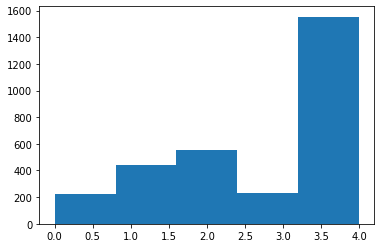

In [46]:
import matplotlib.pyplot as plt
plt.hist(clusters, bins = 5)
plt.show()

In [47]:
## Chceme cluster 3
index = [2]
cluster_index = pd.Series(index)

In [48]:
res = [index for index in range(len(clusters)) if clusters[index] in cluster_index.values] #== 3 or clusters[index] == 4]
#print(res)

In [49]:
len(res)

552

In [50]:
tfidf_vector_cut = tfidf_vector[res,:]

In [51]:
print(tfidf_vector_cut)

  (0, 40)	0.1440331113701829
  (0, 93)	0.14100204514080483
  (0, 323)	0.20149440724869114
  (0, 171)	0.055668555240458634
  (0, 408)	0.06465964556949026
  (0, 2)	0.06952941709664248
  (0, 476)	0.33235439079999424
  (0, 88)	0.06148554690575291
  (0, 119)	0.058808151666692156
  (0, 27)	0.050864464980327345
  (0, 149)	0.06061035802272377
  (0, 226)	0.1092435346460457
  (0, 477)	0.4201180288788679
  (0, 427)	0.06592442481603446
  (0, 464)	0.07054988378415446
  (0, 275)	0.05691796072468043
  (0, 223)	0.055132237013575454
  (0, 122)	0.11978829529044667
  (0, 318)	0.06170214126738034
  (0, 382)	0.06268080406468303
  (0, 29)	0.047477083965827255
  (0, 210)	0.06234918421827749
  (0, 150)	0.05852071824793754
  (0, 76)	0.12428512708802185
  (0, 60)	0.11837631608371131
  :	:
  (551, 146)	0.12422679882139046
  (551, 316)	0.09425340486133271
  (551, 46)	0.22133941821682138
  (551, 480)	0.09021813451695279
  (551, 237)	0.12176232008095252
  (551, 491)	0.11361207985384365
  (551, 26)	0.096031189179781

Above we have cut of tfidf_vector

In [52]:
tfidf_df = pd.DataFrame(tfidf_vector_cut.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # HERE IT CRASHES with too high max_features 

In [53]:
#tfidf_df.loc['00_Document Frequency'] = (tfidf_df > 0).sum()

In [54]:
print(tfidf_df)

          bod      bodu      body    bychom  bychom měli       byť     celou  \
0    0.000000  0.000000  0.069529  0.000000     0.000000  0.000000  0.000000   
1    0.000000  0.000000  0.000000  0.000000     0.000000  0.000000  0.100090   
2    0.079013  0.082143  0.000000  0.000000     0.000000  0.000000  0.000000   
3    0.000000  0.000000  0.000000  0.000000     0.000000  0.000000  0.000000   
4    0.000000  0.000000  0.000000  0.000000     0.000000  0.000000  0.000000   
..        ...       ...       ...       ...          ...       ...       ...   
547  0.000000  0.024600  0.000000  0.017667     0.026554  0.027116  0.125959   
548  0.000000  0.000000  0.000000  0.000000     0.000000  0.000000  0.000000   
549  0.000000  0.000000  0.000000  0.000000     0.000000  0.000000  0.000000   
550  0.000000  0.000000  0.000000  0.000000     0.000000  0.000000  0.000000   
551  0.000000  0.000000  0.000000  0.000000     0.000000  0.000000  0.000000   

         celá      celé      celý  ... 

### new cluster

In [55]:
#from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_vector_cut)

clusters = km.labels_.tolist()

In [56]:
tfidf_df = pd.DataFrame(tfidf_vector_cut.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # HERE IT CRASHES with too high max_features 

In [57]:
tfidf_df['cluster'] = clusters

In [58]:
keywords_extraction(tfidf_df, 5)

cluster       3.000000
samozřejmě    0.067445
teď           0.051280
věci          0.050688
té            0.050510
dtype: float64
cluster        4.000000
návrh          0.102135
návrhu         0.072196
odst           0.061634
pozměňovací    0.055605
dtype: float64
hlasování     0.168855
číslo         0.138080
návrh         0.111644
schůze        0.108831
poslanecké    0.105246
dtype: float64
cluster     2.000000
rozpočtu    0.114017
vláda       0.090520
korun       0.087678
státního    0.083211
dtype: float64
cluster            1.000000
české              0.152032
republiky          0.122989
české republiky    0.114062
evropské           0.096942
dtype: float64


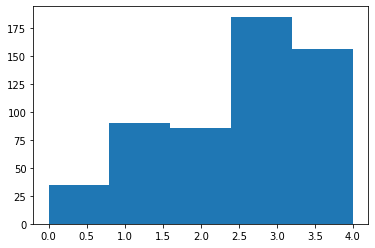

In [59]:
import matplotlib.pyplot as plt
plt.hist(clusters, bins = 5)
plt.show()

In [60]:
## Chceme cluster 3
index = [0]
cluster_index = pd.Series(index)

In [61]:
res = [index for index in range(len(clusters)) if clusters[index] in cluster_index.values] #== 3 or clusters[index] == 4]
#print(res)

In [62]:
len(res)

35

In [63]:
tfidf_vector_cut = tfidf_vector[res,:]

In [64]:
print(tfidf_vector_cut)

  (0, 195)	0.09109912509224026
  (0, 100)	0.12525236293938713
  (0, 490)	0.18310931935571723
  (0, 96)	0.0908737566714757
  (0, 422)	0.09792228890091033
  (0, 125)	0.10104364289677839
  (0, 246)	0.2219549764302469
  (0, 23)	0.09393454168570202
  (0, 6)	0.09887700237828725
  (0, 129)	0.072861150936698
  (0, 345)	0.10007771575980652
  (0, 248)	0.10282939986242043
  (0, 357)	0.18484247219900488
  (0, 431)	0.2363538452503568
  (0, 496)	0.24309361560613998
  (0, 11)	0.1601105374995937
  (0, 434)	0.33362190311781204
  (0, 212)	0.097795421952531
  (0, 21)	0.0935994463001625
  (0, 299)	0.08179273816873277
  (0, 41)	0.3622831893776465
  (0, 398)	0.26820565007545966
  (0, 232)	0.07990979382373933
  (0, 400)	0.16445317512524685
  (0, 37)	0.07040482119254048
  :	:
  (34, 116)	0.06543607918775574
  (34, 300)	0.026677734443229406
  (34, 65)	0.040679553940113786
  (34, 13)	0.06432044446376801
  (34, 347)	0.03196216768689181
  (34, 259)	0.07486215953031833
  (34, 377)	0.02560349539016904
  (34, 184)	0

Above we have cut of tfidf_vector

In [65]:
tfidf_df = pd.DataFrame(tfidf_vector_cut.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # HERE IT CRASHES with too high max_features 

In [66]:
#tfidf_df.loc['00_Document Frequency'] = (tfidf_df > 0).sum()

### last cluster

In [67]:
#from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_vector_cut)

clusters = km.labels_.tolist()

In [68]:
tfidf_df = pd.DataFrame(tfidf_vector_cut.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # HERE IT CRASHES with too high max_features 

In [69]:
tfidf_df['cluster'] = clusters

In [70]:
keywords_extraction(tfidf_df, 5)

cluster    1.000000
financí    0.101572
ministr    0.100759
kč         0.097242
peníze     0.094697
dtype: float64
cluster         4.000000
práce           0.212212
návrh           0.141395
legislativní    0.119312
návrhu          0.102534
dtype: float64
cluster     3.000000
právní      0.096169
oblasti     0.093095
osob        0.090930
opatření    0.088438
dtype: float64
korun                 0.408419
náklady               0.124546
pane                  0.112445
pane místopředsedo    0.095428
místopředsedo         0.095355
dtype: float64
cluster      2.000000
hlasování    0.323081
číslo        0.224583
návrh        0.169367
panu         0.140043
dtype: float64


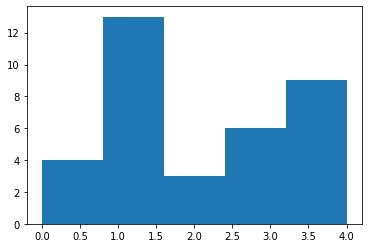

In [71]:
import matplotlib.pyplot as plt
plt.hist(clusters, bins = 5)
plt.show()

In [72]:
## Chceme cluster 1
index = [1]
cluster_index = pd.Series(index)

Menší než 50? -> výpis

In [73]:
res = [index for index in range(len(clusters)) if clusters[index] in cluster_index.values] #== 3 or clusters[index] == 4]
#print(res)

In [74]:
len(res)

13

In [75]:
tfidf_vector_cut = tfidf_vector[res,:]

In [76]:
print(tfidf_vector_cut)

  (0, 231)	0.04703527296805994
  (0, 205)	0.11414360449191228
  (0, 473)	0.08691135749326157
  (0, 83)	0.04433039213635484
  (0, 208)	0.05233062561246555
  (0, 407)	0.035076365698599975
  (0, 328)	0.03857333674453431
  (0, 229)	0.03539565293731092
  (0, 192)	0.05791667458418724
  (0, 224)	0.03771832408788122
  (0, 362)	0.04512972231206212
  (0, 488)	0.04754531850843273
  (0, 449)	0.03505564271173721
  (0, 180)	0.05359998316876447
  (0, 338)	0.05238961500816853
  (0, 17)	0.05355236404624273
  (0, 85)	0.15329124137363
  (0, 444)	0.05662680113131035
  (0, 238)	0.21276708323482985
  (0, 213)	0.04962109965145837
  (0, 346)	0.08687695216111428
  (0, 177)	0.05288448016571795
  (0, 344)	0.05282370156562254
  (0, 178)	0.04382113254711306
  (0, 293)	0.053904798646843034
  :	:
  (12, 142)	0.006485084931409731
  (12, 300)	0.06462563530270204
  (12, 13)	0.01038756269519761
  (12, 25)	0.019051506236618387
  (12, 259)	0.018135028032737994
  (12, 304)	0.01167738579714154
  (12, 136)	0.0063272828569529

Above we have cut of tfidf_vector

In [77]:
tfidf_df = pd.DataFrame(tfidf_vector_cut.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # HERE IT CRASHES with too high max_features 

## draft hierarchic cluster function

In [78]:
#from google.colab import auth
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import glob
import re
import string
from google.colab import drive
#auth.authenticate_user()

In [79]:
drive.mount('/content/drive/')
# Path to our data on google drive
DATA_PATH = "/content/drive/MyDrive/NLP/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [80]:
psp_data = pickle.load(open('/content/drive/MyDrive/NLP/Changed/psp_data_300_no_stopwords.pickle', 'rb'))

In [81]:
test_data = psp_data#.sample(frac=0.2)

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [83]:
tfidf_vectorizer = TfidfVectorizer(input='content', max_features = 500, max_df = 0.7, ngram_range=(1, 2)) # Hopefully stop_words will be filtered by TD-IDF mechanism
# ngram_range=(1, 1) only unigram, ngram_range=(1, 2) uni and bigrams

In [84]:
tfidf_vector = tfidf_vectorizer.fit_transform(test_data['text']) # Run time 146s

In [85]:
from sklearn.cluster import KMeans
import random

In [86]:
def keywords_extraction(data, num_top_words):
  cluster_index = pd.Series(pd.unique(data['cluster']))
  for i in cluster_index:
    df2 = data[data['cluster'] == i].mean(axis=0)
    order = np.argsort(-df2.values)[:num_top_words]
    top_features = df2[order]
    print(top_features)

In [87]:
def hierarchic_K_means(tfidf_vector, tfidf_vectorizer, num_clusters, threshold):
  cluster_size = tfidf_vector.shape[0]
  tfidf_vector_cut2 = tfidf_vector

  while cluster_size > threshold:
    tfidf_vector_cut = tfidf_vector_cut2
    # K-means based on current tfidf_vector
    km = KMeans(n_clusters=num_clusters)
    km.fit(tfidf_vector_cut)
    clusters = km.labels_.tolist()
    tfidf_df = pd.DataFrame(tfidf_vector_cut.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_df['cluster'] = clusters
    # display of keywords per cluster
    keywords_extraction(tfidf_df, num_clusters)
    # here should be made selection of clusters based on selected keyword
    # temporarily this is random
    index = random.randint(0, num_clusters-1)
    print("Selected cluster is:")
    print(index)
    cluster_index = pd.Series(index)
    # These are indices in selected factor
    res = [index for index in range(len(clusters)) if clusters[index] in cluster_index.values] #== 3 or clusters[index] == 4]
    tfidf_vector_cut2 = tfidf_vector_cut[res,:]
    cluster_size = len(res)
    print("Current cluster size is: ")
    print(cluster_size)
    # missing part printing indices/ids of documents in final cluster





In [88]:
num_clusters = 5
threshold = 50
hierarchic_K_means(tfidf_vector, tfidf_vectorizer, num_clusters, threshold)

cluster            2.000000
české              0.152673
republiky          0.125156
evropské           0.122413
české republiky    0.116499
dtype: float64
cluster     1.000000
rozpočtu    0.134424
korun       0.123043
mld         0.092836
státního    0.084869
dtype: float64
samozřejmě    0.056543
těch          0.050731
té            0.044975
teď           0.043100
vláda         0.040138
dtype: float64
cluster        4.000000
návrh          0.117502
návrhu         0.078425
pozměňovací    0.063565
odst           0.056230
dtype: float64
cluster      3.000000
hlasování    0.354298
číslo        0.200065
návrh        0.185712
pořadové     0.166651
dtype: float64
Selected cluster is:
4
Current cluster size is: 
12431
cluster       3.000000
důvody        0.371577
důvodů        0.258337
poslanec      0.211374
pracovních    0.198644
dtype: float64
pozměňovací          0.234870
návrh                0.187493
pozměňovací návrh    0.183486
návrhu               0.105966
návrhy               0.098195


In [89]:
def keywords_extraction2(data, num_top_words):
  cluster_index = pd.Series(pd.unique(data['cluster']))
  for i in cluster_index:
    df2 = data[data['cluster'] == i].mean(axis=0)
    if i == 0:
      order = np.argsort(-df2.values)[:num_top_words]
    else:
      order = np.argsort(-df2.values)[1:num_top_words+1]
    top_features = df2[order]
    print(top_features)

In [90]:
def hierarchic_K_means2(tfidf_vector, tfidf_vectorizer, num_clusters, threshold):
  cluster_size = tfidf_vector.shape[0]
  tfidf_vector_cut2 = tfidf_vector

  while cluster_size > threshold:
    tfidf_vector_cut = tfidf_vector_cut2
    # K-means based on current tfidf_vector
    km = KMeans(n_clusters=num_clusters)
    km.fit(tfidf_vector_cut)
    clusters = km.labels_.tolist()
    tfidf_df = pd.DataFrame(tfidf_vector_cut.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_df['cluster'] = clusters
    # display of keywords per cluster
    keywords_extraction2(tfidf_df, num_clusters)
    # here should be made selection of clusters based on selected keyword
    # temporarily this is random
    index = random.randint(0, num_clusters-1)
    print("Selected cluster is:")
    print(index)
    cluster_index = pd.Series(index)
    # These are indices in selected factor
    res = [index for index in range(len(clusters)) if clusters[index] in cluster_index.values] #== 3 or clusters[index] == 4]
    tfidf_vector_cut2 = tfidf_vector_cut[res,:]
    cluster_size = len(res)
    print("Current cluster size is: ")
    print(cluster_size)
    # missing part printing indices/ids of documents in final cluster

In [91]:
# num_clusters = 5
# threshold = 50
# hierarchic_K_means2(tfidf_vector, tfidf_vectorizer, num_clusters, threshold)

DF for storing top tfidf words for each clustering step

# Here is start? 17.11

In [ ]:
#from google.colab import auth
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import glob
import re
import string
from sklearn.cluster import KMeans
import random
from google.colab import drive
#auth.authenticate_user()

In [ ]:
drive.mount('/content/drive/')
# Path to our data on google drive
DATA_PATH = "/content/drive/MyDrive/NLP/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
psp_data = pickle.load(open('/content/drive/MyDrive/NLP/Changed/psp_data_300_no_stopwords.pickle', 'rb'))

In [189]:
test_data = psp_data.sample(frac=0.2)

Test sample has 20% of our data, i.e. 9790.

In [190]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [191]:
tfidf_vectorizer = TfidfVectorizer(input='content', max_features = 500, max_df = 0.7, ngram_range=(1, 2)) # Hopefully stop_words will be filtered by TD-IDF mechanism
# ngram_range=(1, 1) only unigram, ngram_range=(1, 2) uni and bigrams

In [192]:
tfidf_vector = tfidf_vectorizer.fit_transform(test_data['text']) # Run time 146s

In [193]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names_out()) # HERE IT CRASHES with too high max_features 



```
data_cluster
```
is dataframe which contains Id of the documents and each hierarchic cluster it is part of


In [194]:
test_data['Cluster'] = 0

In [195]:
data_cluster = test_data[['Id', 'Cluster']].copy()

In [196]:
data_cluster.head()

,Id,Cluster
45870,1998_24_01098,0
28763,2006_62_00644,0
5702,2017_54_00305,0
40866,2002_10_00154,0
31720,2006_23_00103,0


In [197]:
#tfidf_df = pd.DataFrame(tfidf_vector_cut.toarray(), columns=tfidf_vectorizer.get_feature_names_out())



```
data_cluster_keys
```
is dataframe which contains means of each tfidf value of featured words for each cluster.
In column cluster are stored "position/path" of each cluster. 


In [198]:
data_cluster_keys = tfidf_df.copy()

In [199]:
data_cluster_keys['cluster'] = 0

In [200]:
data_cluster_keys.head(10)

,bod,bodu,body,bychom,bychom měli,byť,celou,celá,celé,celý,...,říkal,říká,říkám,řízení,škol,školství,školy,životního,životního prostředí,cluster
0,0.379871,0.000000,0.092642,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.113671,0.0,0.000000,0.000000,0.0,...,0.103539,0.000000,0.0,0.0,0.285437,0.133055,0.276923,0.0,0.0,0
2,0.000000,0.047540,0.000000,0.000000,0.000000,0.000000,0.0,0.051115,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
3,0.265553,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
4,0.000000,0.200849,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
5,0.168040,0.000000,0.136605,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
7,0.060682,0.063229,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.060879,0.0,...,0.000000,0.059924,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
8,0.000000,0.071136,0.000000,0.154747,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0
9,0.000000,0.000000,0.000000,0.041019,0.060401,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0


In [201]:
def keywords_extraction3(data, num_top_words):
  cluster_index = pd.Series(pd.unique(data['cluster']))
  for i in cluster_index:
    df2 = data[data['cluster'] == i].mean(axis=0)
    if i == 0:
      order = np.argsort(-df2.values)[:num_top_words]
    else:
      order = np.argsort(-df2.values)[1:num_top_words+1]
    top_features = df2[order]
    return top_features

In [202]:
cluster_size = tfidf_vector.shape[0]
tfidf_vector_cut2 = tfidf_vector
level = 0
num_top_words = 5

In [203]:
#while cluster_size > threshold:
tfidf_vector_cut = tfidf_vector_cut2
# K-means based on current tfidf_vector
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_vector_cut)
clusters = km.labels_.tolist()
tfidf_df = pd.DataFrame(tfidf_vector_cut.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['cluster'] = clusters
if cluster_size == tfidf_vector.shape[0]:
  data_cluster['Cluster'] = clusters
# display of keywords per cluster
cluster_index = np.sort(pd.Series(pd.unique(tfidf_df['cluster'])))
for q in cluster_index:
  df2 = tfidf_df[tfidf_df['cluster'] == q].mean(axis=0)
  data_cluster_keys.loc[q] = tfidf_df[tfidf_df['cluster'] == q].mean(axis=0)
  if q == 0:
    order = np.argsort(-df2.values)[:num_top_words]
  else:
    order = np.argsort(-df2.values)[1:num_top_words+1]
  #data_cluster_keys['Keywords'].loc[q] = df2[order]
  #data_cluster_keys.loc[q] = pd.Series({'Clusters':q, 'Keywords':df2[order]})
# here should be made selection of clusters based on selected keyword
# temporarily this is random
index = random.randint(0, num_clusters-1)
print("Selected cluster is:")
print(index)
cluster_index = pd.Series(index)
# These are indices in selected factor
res = [index for index in range(len(clusters)) if clusters[index] in cluster_index.values] #== 3 or clusters[index] == 4]
tfidf_vector_cut2 = tfidf_vector_cut[res,:]
cluster_size = len(res)

Selected cluster is:
2


In [204]:
data_cluster.head()

,Id,Cluster
45870,1998_24_01098,2
28763,2006_62_00644,0
5702,2017_54_00305,2
40866,2002_10_00154,2
31720,2006_23_00103,2


In [205]:
data_cluster_keys.head()

,bod,bodu,body,bychom,bychom měli,byť,celou,celá,celé,celý,...,říkal,říká,říkám,řízení,škol,školství,školy,životního,životního prostředí,cluster
0,0.010133,0.006880,0.004393,0.032116,0.012671,0.012229,0.013679,0.012171,0.014290,0.010930,...,0.020886,0.020084,0.021169,0.023586,0.012990,0.014695,0.014820,0.012910,0.012547,0
1,0.005098,0.005800,0.002673,0.019508,0.006055,0.007275,0.006642,0.006410,0.009881,0.008174,...,0.010669,0.010834,0.007978,0.008795,0.010338,0.021642,0.010235,0.007707,0.006896,1
2,0.029967,0.017268,0.014559,0.018190,0.005877,0.007338,0.005754,0.005688,0.006863,0.007166,...,0.004909,0.006608,0.005179,0.039886,0.007289,0.005009,0.006467,0.010471,0.008980,2
3,0.015292,0.010631,0.004439,0.022682,0.009558,0.008286,0.010042,0.008969,0.013493,0.006698,...,0.007630,0.011568,0.008570,0.017933,0.002808,0.003616,0.002062,0.009572,0.009332,3
4,0.142850,0.074021,0.047299,0.016580,0.004728,0.000595,0.000601,0.000385,0.001811,0.001951,...,0.001244,0.000992,0.001544,0.001312,0.000000,0.002782,0.000879,0.002086,0.002159,4


## Klastrovani 2 uroven

In [206]:
km = KMeans(n_clusters=num_clusters)

In [207]:
#data_cluster_keys['cluster2'] = 0

In [208]:
#data_cluster.loc[data_cluster.Cluster == 3, 'Cluster2'] = 1
#data_cluster.head()

In [209]:
for k in range(num_clusters):
  cluster_index = pd.Series(k)
  # New part = we take only data from current cluster
  #clusters = data_cluster['Cluster'] # puvodni klastry
  res = (data_cluster['Cluster'] == k)
  #res = [k for k in range(len(clusters)) if clusters[k] in cluster_index.values] #== 3 or clusters[index] == 4]
  tfidf_vector_cut2 = tfidf_vector[res,:] # delame cut z puvodniho
  km.fit(tfidf_vector_cut2)
  clusters2 = km.labels_.tolist()
  tfidf_df = pd.DataFrame(tfidf_vector_cut2.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
  tfidf_df['cluster'] = clusters2

  data_cluster.loc[data_cluster.Cluster == k, 'Cluster2'] = clusters2
  cluster_index = np.sort(pd.Series(pd.unique(tfidf_df['cluster'])))
  for q in cluster_index:
    df2 = tfidf_df[tfidf_df['cluster'] == q].mean(axis=0)
    data_cluster_keys.loc[(k+1)*num_clusters+q] = tfidf_df[tfidf_df['cluster'] == q].mean(axis=0)
    #print((k+1)*num_clusters+q)
    if q == 0:
      order = np.argsort(-df2.values)[:num_top_words]
    else:
      order = np.argsort(-df2.values)[1:num_top_words+1]
    #data_cluster_keys['Keywords'].loc[q] = df2[order]
    #data_cluster_keys.loc[q] = pd.Series({'Clusters':q, 'Keywords':df2[order]})
  # here should be made selection of clusters based on selected keyword
  # temporarily this is random
  index = random.randint(0, num_clusters-1)
  print("Selected cluster is:")
  print(index)

Selected cluster is:
1
Selected cluster is:
1
Selected cluster is:
1
Selected cluster is:
2
Selected cluster is:
2


In [210]:
data_cluster['Cluster2'] = data_cluster['Cluster2'].astype(int)

In [211]:
data_cluster.head(10)

,Id,Cluster,Cluster2
45870,1998_24_01098,2,4
28763,2006_62_00644,0,0
5702,2017_54_00305,2,2
40866,2002_10_00154,2,0
31720,2006_23_00103,2,2
10303,2017_24_01212,2,3
37793,2002_31_00784,0,0
3442,2017_98_01757,0,2
46667,1998_19_01114,2,0
19719,2013_20_00385,0,1


In [212]:
data_cluster_keys.head(50)

,bod,bodu,body,bychom,bychom měli,byť,celou,celá,celé,celý,...,říkal,říká,říkám,řízení,škol,školství,školy,životního,životního prostředí,cluster
0,0.010133,0.006880,0.004393,0.032116,0.012671,0.012229,0.013679,0.012171,0.014290,0.010930,...,0.020886,0.020084,0.021169,0.023586,0.012990,0.014695,0.014820,0.012910,0.012547,0
1,0.005098,0.005800,0.002673,0.019508,0.006055,0.007275,0.006642,0.006410,0.009881,0.008174,...,0.010669,0.010834,0.007978,0.008795,0.010338,0.021642,0.010235,0.007707,0.006896,1
2,0.029967,0.017268,0.014559,0.018190,0.005877,0.007338,0.005754,0.005688,0.006863,0.007166,...,0.004909,0.006608,0.005179,0.039886,0.007289,0.005009,0.006467,0.010471,0.008980,2
3,0.015292,0.010631,0.004439,0.022682,0.009558,0.008286,0.010042,0.008969,0.013493,0.006698,...,0.007630,0.011568,0.008570,0.017933,0.002808,0.003616,0.002062,0.009572,0.009332,3
4,0.142850,0.074021,0.047299,0.016580,0.004728,0.000595,0.000601,0.000385,0.001811,0.001951,...,0.001244,0.000992,0.001544,0.001312,0.000000,0.002782,0.000879,0.002086,0.002159,4
5,0.013178,0.003336,0.004916,0.028857,0.011637,0.008443,0.013228,0.007519,0.014583,0.009164,...,0.008512,0.012285,0.019890,0.012450,0.148767,0.148979,0.164158,0.001193,0.000000,0
6,0.014449,0.009083,0.007569,0.023132,0.010264,0.011407,0.013149,0.012259,0.014989,0.007448,...,0.018330,0.021092,0.015464,0.018383,0.002935,0.004532,0.003086,0.003262,0.002257,1
7,0.008451,0.006198,0.003433,0.037749,0.014883,0.013189,0.013815,0.013119,0.014229,0.013102,...,0.023987,0.021976,0.024685,0.027623,0.002999,0.004802,0.004231,0.003044,0.002613,2
8,0.006614,0.008163,0.001567,0.021986,0.005838,0.011412,0.011356,0.008684,0.013558,0.009164,...,0.017602,0.011488,0.018601,0.013991,0.003609,0.005895,0.003797,0.002420,0.001084,3
9,0.007098,0.007066,0.001396,0.027730,0.007518,0.011193,0.019667,0.011052,0.011157,0.006883,...,0.018168,0.012138,0.011734,0.031983,0.000547,0.003288,0.000630,0.267685,0.275724,4


## Klastrovani 3 uroven

In [213]:
for k in range(num_clusters):
  for m in range(num_clusters):
    cluster_index = pd.Series(k)
    # New part = we take only data from current cluster
    #clusters = data_cluster['Cluster'] # puvodni klastry
    res = ((data_cluster['Cluster'] == k) & (data_cluster['Cluster2'] == m))
    #res = [k for k in range(len(clusters)) if clusters[k] in cluster_index.values] #== 3 or clusters[index] == 4]
    tfidf_vector_cut2 = tfidf_vector[res,:] # delame cut z puvodniho
    km.fit(tfidf_vector_cut2)
    clusters3 = km.labels_.tolist()
    tfidf_df = pd.DataFrame(tfidf_vector_cut2.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_df['cluster'] = clusters3

    data_cluster.loc[((data_cluster.Cluster == k) & (data_cluster.Cluster2 == m)), 'Cluster3'] = clusters3
    cluster_index = np.sort(pd.Series(pd.unique(tfidf_df['cluster'])))
    for q in cluster_index:
      df2 = tfidf_df[tfidf_df['cluster'] == q].mean(axis=0)
      # Below '(k+1)*num_clusters+(m+1)*num_clusters*num_clusters+q' means index
      data_cluster_keys.loc[(k+1)*num_clusters*num_clusters+(m+1)*num_clusters+q] = tfidf_df[tfidf_df['cluster'] == q].mean(axis=0)
      #print((k+1)*num_clusters+q)
      if q == 0:
        order = np.argsort(-df2.values)[:num_top_words]
      else:
        order = np.argsort(-df2.values)[1:num_top_words+1]
      #data_cluster_keys['Keywords'].loc[q] = df2[order]
      #data_cluster_keys.loc[q] = pd.Series({'Clusters':q, 'Keywords':df2[order]})
    # here should be made selection of clusters based on selected keyword
    # temporarily this is random
    index = random.randint(0, num_clusters-1)
    #print("Selected cluster is:")
    #print(index)

In [214]:
data_cluster['Cluster3'] = data_cluster['Cluster3'].astype(int)

In [215]:
data_cluster.head(100)

,Id,Cluster,Cluster2,Cluster3
45870,1998_24_01098,2,4,2
28763,2006_62_00644,0,0,3
5702,2017_54_00305,2,2,4
40866,2002_10_00154,2,0,1
31720,2006_23_00103,2,2,1
...,...,...,...,...
38543,2002_27_01126,2,2,3
9457,2017_28_00246,0,2,3
48788,1998_7_00012,2,1,1
19176,2013_25_01586,2,0,2


In [216]:
data_cluster_keys['cluster'] = data_cluster_keys['cluster'].astype(int)

In [217]:
data_cluster_keys.head(157)

,bod,bodu,body,bychom,bychom měli,byť,celou,celá,celé,celý,...,říkal,říká,říkám,řízení,škol,školství,školy,životního,životního prostředí,cluster
0,0.010133,0.006880,0.004393,0.032116,0.012671,0.012229,0.013679,0.012171,0.014290,0.010930,...,0.020886,0.020084,0.021169,0.023586,0.012990,0.014695,0.014820,0.012910,0.012547,0
1,0.005098,0.005800,0.002673,0.019508,0.006055,0.007275,0.006642,0.006410,0.009881,0.008174,...,0.010669,0.010834,0.007978,0.008795,0.010338,0.021642,0.010235,0.007707,0.006896,1
2,0.029967,0.017268,0.014559,0.018190,0.005877,0.007338,0.005754,0.005688,0.006863,0.007166,...,0.004909,0.006608,0.005179,0.039886,0.007289,0.005009,0.006467,0.010471,0.008980,2
3,0.015292,0.010631,0.004439,0.022682,0.009558,0.008286,0.010042,0.008969,0.013493,0.006698,...,0.007630,0.011568,0.008570,0.017933,0.002808,0.003616,0.002062,0.009572,0.009332,3
4,0.142850,0.074021,0.047299,0.016580,0.004728,0.000595,0.000601,0.000385,0.001811,0.001951,...,0.001244,0.000992,0.001544,0.001312,0.000000,0.002782,0.000879,0.002086,0.002159,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,0.181941,0.029211,0.229112,0.020484,0.010441,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.004819,0.000000,0.000000,0.000000,0.015267,0.000000,0.000000,0.000000,2
153,0.007997,0.016605,0.008119,0.008678,0.005370,0.000000,0.007092,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
154,0.133403,0.045517,0.056241,0.015480,0.004904,0.000000,0.005445,0.000000,0.003569,0.004403,...,0.000000,0.000000,0.000000,0.006104,0.000000,0.000000,0.000000,0.000000,0.000000,4
155,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.061726,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


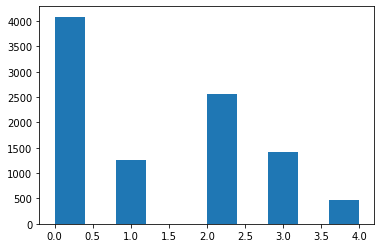

In [218]:
import matplotlib.pyplot as plt
plt.hist(data_cluster['Cluster'])
plt.show()

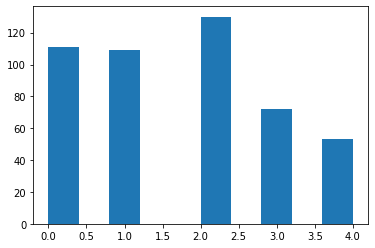

In [219]:
plt.hist(data_cluster[data_cluster['Cluster'] == 4]['Cluster2'])
plt.show()

In [220]:
help = data_cluster[data_cluster['Cluster'] == 4].copy()

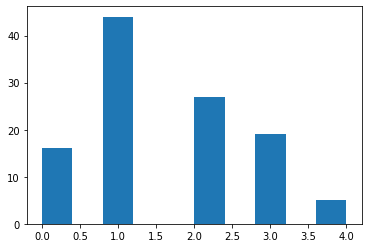

In [221]:
plt.hist(help[help['Cluster2'] == 0]['Cluster3'])
plt.show()

## Klastrovani 4 uroven

Below can be problem because for KMeans must be fulfiled condition n_samples=4 should be >= n_clusters=5

In [222]:
for w in range(num_clusters):
  for k in range(num_clusters):
    for m in range(num_clusters):
      cluster_index = pd.Series(k)
      # New part = we take only data from current cluster
      #clusters = data_cluster['Cluster'] # puvodni klastry
      res = ((data_cluster['Cluster'] == w) & ((data_cluster['Cluster2'] == k) & (data_cluster['Cluster3'] == m)))
      #res = [k for k in range(len(clusters)) if clusters[k] in cluster_index.values] #== 3 or clusters[index] == 4]
      tfidf_vector_cut2 = tfidf_vector[res,:] # delame cut z puvodniho
      km.fit(tfidf_vector_cut2)
      clusters4 = km.labels_.tolist()
      tfidf_df = pd.DataFrame(tfidf_vector_cut2.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
      tfidf_df['cluster'] = clusters4

      data_cluster.loc[((data_cluster.Cluster == w) & ((data_cluster.Cluster2 == k) & (data_cluster.Cluster3 == m))), 'Cluster4'] = clusters4
      cluster_index = np.sort(pd.Series(pd.unique(tfidf_df['cluster'])))
      for q in cluster_index:
        df2 = tfidf_df[tfidf_df['cluster'] == q].mean(axis=0)
        # Below '(k+1)*num_clusters+(m+1)*num_clusters*num_clusters+q' means index
        data_cluster_keys.loc[(w+1)*num_clusters**3+(k+1)*num_clusters*num_clusters+(m+1)*num_clusters+q] = tfidf_df[tfidf_df['cluster'] == q].mean(axis=0)
        #print((k+1)*num_clusters+q)
        if q == 0:
          order = np.argsort(-df2.values)[:num_top_words]
        else:
          order = np.argsort(-df2.values)[1:num_top_words+1]
        #data_cluster_keys['Keywords'].loc[q] = df2[order]
        #data_cluster_keys.loc[q] = pd.Series({'Clusters':q, 'Keywords':df2[order]})
      # here should be made selection of clusters based on selected keyword
      # temporarily this is random
      index = random.randint(0, num_clusters-1)
      #print("Selected cluster is:")
      #print(index)

In [223]:
data_cluster['Cluster4'] = data_cluster['Cluster4'].astype(int)

In [224]:
data_cluster.head(100)

,Id,Cluster,Cluster2,Cluster3,Cluster4
45870,1998_24_01098,2,4,2,4
28763,2006_62_00644,0,0,3,2
5702,2017_54_00305,2,2,4,1
40866,2002_10_00154,2,0,1,3
31720,2006_23_00103,2,2,1,2
...,...,...,...,...,...
38543,2002_27_01126,2,2,3,0
9457,2017_28_00246,0,2,3,1
48788,1998_7_00012,2,1,1,0
19176,2013_25_01586,2,0,2,0


In [225]:
data_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9790 entries, 45870 to 11870
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        9790 non-null   object
 1   Cluster   9790 non-null   int64 
 2   Cluster2  9790 non-null   int64 
 3   Cluster3  9790 non-null   int64 
 4   Cluster4  9790 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 458.9+ KB


In [226]:
data_cluster_keys['cluster'] = data_cluster_keys['cluster'].astype(int)

In [227]:
data_cluster_keys.head(783)

,bod,bodu,body,bychom,bychom měli,byť,celou,celá,celé,celý,...,říkal,říká,říkám,řízení,škol,školství,školy,životního,životního prostředí,cluster
0,0.010133,0.006880,0.004393,0.032116,0.012671,0.012229,0.013679,0.012171,0.014290,0.010930,...,0.020886,0.020084,0.021169,0.023586,0.012990,0.014695,0.014820,0.012910,0.012547,0
1,0.005098,0.005800,0.002673,0.019508,0.006055,0.007275,0.006642,0.006410,0.009881,0.008174,...,0.010669,0.010834,0.007978,0.008795,0.010338,0.021642,0.010235,0.007707,0.006896,1
2,0.029967,0.017268,0.014559,0.018190,0.005877,0.007338,0.005754,0.005688,0.006863,0.007166,...,0.004909,0.006608,0.005179,0.039886,0.007289,0.005009,0.006467,0.010471,0.008980,2
3,0.015292,0.010631,0.004439,0.022682,0.009558,0.008286,0.010042,0.008969,0.013493,0.006698,...,0.007630,0.011568,0.008570,0.017933,0.002808,0.003616,0.002062,0.009572,0.009332,3
4,0.142850,0.074021,0.047299,0.016580,0.004728,0.000595,0.000601,0.000385,0.001811,0.001951,...,0.001244,0.000992,0.001544,0.001312,0.000000,0.002782,0.000879,0.002086,0.002159,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,0.137501,0.000000,0.000000,0.051944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
779,0.229231,0.000000,0.000000,0.043299,0.063758,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


780 is cut

In [228]:
cluster_keywords = data_cluster_keys.head(780).copy()

## Saving usefull data

In [229]:
test_data.to_pickle("./test_data_clustering.pickle")

In [230]:
data_cluster.to_pickle("./data_cluster_sample.pickle")

In [231]:
cluster_keywords.to_pickle("./cluster_keywords_sample.pickle")

## Konec klastrovani